In [28]:
%matplotlib inline

In [115]:
from datetime import datetime

In [23]:
#renderer
from PIL import ImageFont
import numpy as np
import cv2

# char render
def render(text, font=None):
    if font is None:
        font = ImageFont.truetype("/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc", 32)
    mask = font.getmask(text)
    size = mask.size[::-1]
    a = np.asarray(mask).reshape(size) / 255
    res = cv2.resize(a, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
    return res

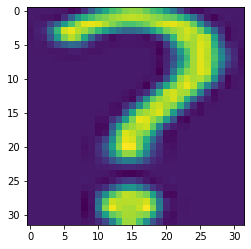

In [29]:
# test renderer
b = np.zeros((10, 32,32))
b[0] = render('?')

from matplotlib.pyplot import imshow
imshow(b[0])

In [33]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/language_model/data_utils.py
import torch
import os
import re

class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __len__(self):
        return len(self.word2idx)


class Corpus(object):
    def __init__(self):
        self.dictionary = Dictionary()

    def get_data(self, path, batch_size=20):
        # Add words to the dictionary
#         with open(path, 'r') as f:
#             tokens = 0
#             for line in f:
#                 words = line.split() + ['<eos>']
#                 tokens += len(words)
#                 for word in words: 
#                     self.dictionary.add_word(word)  

        # split words to char and add to dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                line = ' '.join(line) # split words to char
                line = re.sub(r'[" "]+', ' ', line) # remove continous space
                chars = line.split() + ['¿'] # ¿ as <eos>
                tokens += len(chars)
                for char in chars:
                    self.dictionary.add_word(char)
        
        # Tokenize the file content
        ids = torch.LongTensor(tokens)
        token = 0
        with open(path, 'r') as f:
            for line in f:
                line = ' '.join(line) # split words to char
                line = re.sub(r'[" "]+', ' ', line) # remove continous space
                chars = line.split() + ['¿'] # ¿ as <eos>
                for char in chars:
                    ids[token] = self.dictionary.word2idx[char]
                    token += 1
        num_batches = ids.size(0) // batch_size
        ids = ids[:num_batches*batch_size]
        return ids.view(batch_size, -1)

In [ ]:
# test corpus
batch_size = 4
seq_length = 30
corpus = Corpus()
ids = corpus.get_data('icwb2-data/training/msr_training.utf8', batch_size)

In [44]:
print(ids[:, 0:seq_length])
print(list(corpus.dictionary.word2idx.keys())[:10])
len(corpus.dictionary)

tensor([[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
           12,   13,   14,   15,   16,   17,   18,   19,   20,   21,    7,   22,
           23,   24,   25,   18,   10,   11],
        [ 133,  519,  326,  391,   96, 1921, 1919, 1919,  577,  503,   29, 1004,
          131, 2179,   18,   34,  872,  744,   96,  677,  498,   37,   38, 1403,
          153,  335, 1620,  214, 1597,   13],
        [ 584,  496,  582,   13,   22,  300,  496,  582,   18, 1481,   39,  496,
         1274,   37,   38,  110,   82,   67,   25,  105,   92,  120,  319,  792,
            8,    7,  399,  572,  982,  365],
        [ 110,    8,   22,  243, 1199,  394,  156,  140,  103,  223, 1171,  694,
           83,   18,  503,  326,  348,  874,   13,  548,   78,   79, 1198,  676,
         1270,  350,  218,  408,  454,  977]])
['“', '人', '们', '常', '说', '生', '活', '是', '一', '部']


5168

In [4]:
import torch.nn as nn
import numpy as np
from torch.nn.utils import clip_grad_norm_

In [111]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [43]:
# RNN based language model
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, char_id, char_cnn_o, h):
        # Embed word ids to vectors
        x = self.embed(char_id) + char_cnn_o
        
        # Forward propagate LSTM
        out, h = self.gru(x, h)
        
        # Reshape output to (batch_size*sequence_length, hidden_size)
        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        
        # Decode hidden states of all time steps
        out = self.linear(out)
        return out, h

In [107]:
"""
Utility function for computing output of convolutions
takes a tuple of (h,w) and returns a tuple of (h,w)
"""
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    if type(stride) is not tuple:
        stride = (stride, stride)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride[0]) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride[1]) + 1)
    return h, w

# Dai et al. 's CNN glyph encoder
class Dai_CNN(nn.Module):
    def __init__(self, embed_size, input_size=(32, 32)):
        super(Dai_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (7, 7), stride=(2,2))
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.zeros_(self.conv1.bias)
        h, w = conv_output_shape(input_size, (7, 7), (2, 2))
        
        self.conv2 = nn.Conv2d(32, 16, (5, 5), stride=(2,2))
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.zeros_(self.conv2.bias)
        h, w = conv_output_shape((h, w), (5, 5), (2, 2))
                
        self.fc = nn.Linear(16*h*w, embed_size)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        torch.nn.init.zeros_(self.fc.bias)
        
        self.h, self.w = h, w
        
    def forward(self, char_img):
        b = char_img.size(0)
        x = self.conv1(char_img)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = x.view(-1, 16*self.h*self.w)
        return self.fc(x)

In [88]:
# Hyper-parameters
embed_size = 300
hidden_size = 128
num_layers = 1
num_epochs = 50
batch_size = 16
seq_length = 30
learning_rate = 1e-3

# Load dataset
corpus = Corpus()
ids = corpus.get_data('icwb2-data/training/msr_training.utf8', batch_size)
vocab_size = len(corpus.dictionary)
num_batches = ids.size(1) // seq_length

In [89]:
# save char images for reference
for char, idx in corpus.dictionary.word2idx.items():
    np.save(f'char_img/noto_CJK/msr/{idx}.npy', render(char))

In [114]:
model = RNNLM(vocab_size, embed_size, hidden_size, num_layers).to(device)
cnn_encoder = Dai_CNN(embed_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Truncated backpropagation
def detach(state):
    return state.detach()

In [116]:
# Train the model
for epoch in range(num_epochs):
    # Set initial hidden and cell states
    state = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    
    for i in range(0, ids.size(1) - seq_length, seq_length):
        # Get mini-batch inputs and targets
        inputs = ids[:, i:i+seq_length].to(device)
        targets = ids[:, (i+1):(i+1)+seq_length].to(device)
        
        # Get images
        images = np.zeros((inputs.size(0), inputs.size(1), 32, 32, 1))
        for b, seq in enumerate(ids):
            for s, idx in enumerate(ids[b][i:i+seq_length]):
                images[b, s] = np.load(f'char_img/noto_CJK/msr/{idx}.npy').reshape(32,32,1)
        images = torch.from_numpy(images).float().to(device) # B N H W C
        images = images.view(-1, 32, 32, 1) # B*N H W C
        images = images.permute(0, 3, 1, 2) # from B*N H W C to B*N C H W
        
        # Get encoded images
        cnn_o = cnn_encoder(images)
        cnn_o = torch.reshape(cnn_o, (inputs.size(0), inputs.size(1), -1))
               
        # Forward pass
        state = detach(state)
        outputs, state = model(inputs, cnn_o, state)
        loss = criterion(outputs, targets.reshape(-1))
        
        # Backward and optimize
        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        step = (i+1) // seq_length
        if step % 1000 == 0:
            print ('{} Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                   .format(datetime.now(), epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))

2019-11-15 20:35:33.248664 Epoch [1/50], Step[0/8619], Loss: 8.5738, Perplexity: 5291.28
2019-11-15 20:38:05.545137 Epoch [1/50], Step[1000/8619], Loss: 4.8257, Perplexity: 124.67
2019-11-15 20:40:28.080864 Epoch [1/50], Step[2000/8619], Loss: 4.7048, Perplexity: 110.47
2019-11-15 20:42:54.297927 Epoch [1/50], Step[3000/8619], Loss: 4.3127, Perplexity: 74.64
2019-11-15 20:45:18.832006 Epoch [1/50], Step[4000/8619], Loss: 4.3863, Perplexity: 80.34
2019-11-15 20:47:38.981444 Epoch [1/50], Step[5000/8619], Loss: 4.3070, Perplexity: 74.22
2019-11-15 20:49:58.340317 Epoch [1/50], Step[6000/8619], Loss: 4.4113, Perplexity: 82.38
2019-11-15 20:52:19.563799 Epoch [1/50], Step[7000/8619], Loss: 4.4780, Perplexity: 88.06
2019-11-15 20:54:37.744089 Epoch [1/50], Step[8000/8619], Loss: 4.3771, Perplexity: 79.61
2019-11-15 20:56:04.055494 Epoch [2/50], Step[0/8619], Loss: 4.2765, Perplexity: 71.99
2019-11-15 20:58:19.190925 Epoch [2/50], Step[1000/8619], Loss: 3.9914, Perplexity: 54.13
2019-11-15 2

2019-11-15 23:58:52.471713 Epoch [11/50], Step[2000/8619], Loss: 3.9180, Perplexity: 50.30
2019-11-16 00:01:07.866914 Epoch [11/50], Step[3000/8619], Loss: 3.7297, Perplexity: 41.67
2019-11-16 00:03:29.224061 Epoch [11/50], Step[4000/8619], Loss: 3.6256, Perplexity: 37.55
2019-11-16 00:05:50.479692 Epoch [11/50], Step[5000/8619], Loss: 3.8179, Perplexity: 45.51
2019-11-16 00:08:08.455362 Epoch [11/50], Step[6000/8619], Loss: 3.9802, Perplexity: 53.53
2019-11-16 00:10:28.785357 Epoch [11/50], Step[7000/8619], Loss: 3.9639, Perplexity: 52.66
2019-11-16 00:12:45.263853 Epoch [11/50], Step[8000/8619], Loss: 3.9923, Perplexity: 54.18
2019-11-16 00:14:10.907260 Epoch [12/50], Step[0/8619], Loss: 3.9282, Perplexity: 50.82
2019-11-16 00:16:27.539015 Epoch [12/50], Step[1000/8619], Loss: 3.6994, Perplexity: 40.42
2019-11-16 00:18:51.176727 Epoch [12/50], Step[2000/8619], Loss: 3.9268, Perplexity: 50.74
2019-11-16 00:21:12.073478 Epoch [12/50], Step[3000/8619], Loss: 3.7216, Perplexity: 41.33
20

2019-11-16 03:19:27.798505 Epoch [21/50], Step[3000/8619], Loss: 3.6500, Perplexity: 38.48
2019-11-16 03:21:43.420483 Epoch [21/50], Step[4000/8619], Loss: 3.5356, Perplexity: 34.32
2019-11-16 03:23:58.810785 Epoch [21/50], Step[5000/8619], Loss: 3.8046, Perplexity: 44.91
2019-11-16 03:26:17.208803 Epoch [21/50], Step[6000/8619], Loss: 3.8892, Perplexity: 48.87
2019-11-16 03:28:37.925157 Epoch [21/50], Step[7000/8619], Loss: 3.8983, Perplexity: 49.32
2019-11-16 03:30:51.912391 Epoch [21/50], Step[8000/8619], Loss: 3.9737, Perplexity: 53.18
2019-11-16 03:32:18.529066 Epoch [22/50], Step[0/8619], Loss: 3.8400, Perplexity: 46.52
2019-11-16 03:34:35.666008 Epoch [22/50], Step[1000/8619], Loss: 3.6326, Perplexity: 37.81
2019-11-16 03:36:55.298365 Epoch [22/50], Step[2000/8619], Loss: 3.8390, Perplexity: 46.48
2019-11-16 03:39:11.786274 Epoch [22/50], Step[3000/8619], Loss: 3.6508, Perplexity: 38.51
2019-11-16 03:41:29.846537 Epoch [22/50], Step[4000/8619], Loss: 3.5209, Perplexity: 33.82
20

2019-11-16 06:38:49.960637 Epoch [31/50], Step[4000/8619], Loss: 3.4803, Perplexity: 32.47
2019-11-16 06:41:10.279762 Epoch [31/50], Step[5000/8619], Loss: 3.7953, Perplexity: 44.49
2019-11-16 06:43:26.082049 Epoch [31/50], Step[6000/8619], Loss: 3.8846, Perplexity: 48.65
2019-11-16 06:45:42.763559 Epoch [31/50], Step[7000/8619], Loss: 3.8498, Perplexity: 46.98
2019-11-16 06:48:01.530795 Epoch [31/50], Step[8000/8619], Loss: 3.9838, Perplexity: 53.72
2019-11-16 06:49:31.990876 Epoch [32/50], Step[0/8619], Loss: 3.8078, Perplexity: 45.05
2019-11-16 06:51:51.706573 Epoch [32/50], Step[1000/8619], Loss: 3.6077, Perplexity: 36.88
2019-11-16 06:54:12.156310 Epoch [32/50], Step[2000/8619], Loss: 3.8347, Perplexity: 46.28
2019-11-16 06:56:28.764737 Epoch [32/50], Step[3000/8619], Loss: 3.6356, Perplexity: 37.92
2019-11-16 06:58:44.462308 Epoch [32/50], Step[4000/8619], Loss: 3.4901, Perplexity: 32.79
2019-11-16 07:00:59.735360 Epoch [32/50], Step[5000/8619], Loss: 3.8108, Perplexity: 45.19
20

2019-11-16 10:00:07.374116 Epoch [41/50], Step[5000/8619], Loss: 3.7959, Perplexity: 44.52
2019-11-16 10:02:22.991627 Epoch [41/50], Step[6000/8619], Loss: 3.8502, Perplexity: 47.00
2019-11-16 10:04:38.438537 Epoch [41/50], Step[7000/8619], Loss: 3.8319, Perplexity: 46.15
2019-11-16 10:06:58.481431 Epoch [41/50], Step[8000/8619], Loss: 3.9722, Perplexity: 53.10
2019-11-16 10:08:26.418991 Epoch [42/50], Step[0/8619], Loss: 3.7645, Perplexity: 43.14
2019-11-16 10:10:41.495993 Epoch [42/50], Step[1000/8619], Loss: 3.6258, Perplexity: 37.56
2019-11-16 10:12:56.292149 Epoch [42/50], Step[2000/8619], Loss: 3.7981, Perplexity: 44.61
2019-11-16 10:15:14.561289 Epoch [42/50], Step[3000/8619], Loss: 3.6217, Perplexity: 37.40
2019-11-16 10:17:32.155865 Epoch [42/50], Step[4000/8619], Loss: 3.5082, Perplexity: 33.39
2019-11-16 10:19:51.597347 Epoch [42/50], Step[5000/8619], Loss: 3.7891, Perplexity: 44.22
2019-11-16 10:22:08.431375 Epoch [42/50], Step[6000/8619], Loss: 3.8843, Perplexity: 48.63
20

In [134]:
perplexity = .0
num_step = 0
for i in range(0, ids.size(1) - seq_length, seq_length):
    # Get mini-batch inputs and targets
    inputs = ids[:, i:i+seq_length].to(device)
    targets = ids[:, (i+1):(i+1)+seq_length].to(device)

    # Get images
    images = np.zeros((inputs.size(0), inputs.size(1), 32, 32, 1))
    for b, seq in enumerate(ids):
        for s, idx in enumerate(ids[b][i:i+seq_length]):
            images[b, s] = np.load(f'char_img/noto_CJK/msr/{idx}.npy').reshape(32,32,1)
    images = torch.from_numpy(images).float().to(device) # B N H W C
    images = images.view(-1, 32, 32, 1) # B*N H W C
    images = images.permute(0, 3, 1, 2) # from B*N H W C to B*N C H W

    # Get encoded images
    cnn_o = cnn_encoder(images)
    cnn_o = torch.reshape(cnn_o, (inputs.size(0), inputs.size(1), -1))

    # Forward pass
    state = detach(state)
    outputs, state = model(inputs, cnn_o, state)
    loss = criterion(outputs, targets.reshape(-1))

    # Backward and optimize
    model.zero_grad()
    loss.backward()
    clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    
    perplexity += np.exp(loss.item())

    num_step += 1
    
print(f"Train Perplexity: {perplexity / num_step}")

Train Perplexity: 43.0105865161436


In [131]:
test_ids = corpus.get_data('icwb2-data/testing/msr_test.utf8', batch_size)
# filter out unknown character
test_ids = test_ids.view(-1)
mask = test_ids < vocab_size
test_ids = test_ids[mask]
num_batches = test_ids.size(0) // batch_size
test_ids = test_ids[:num_batches*batch_size]
test_ids = test_ids.view(batch_size, -1)

In [133]:
perplexity = .0
num_step = 0
for i in range(0, test_ids.size(1) - seq_length, seq_length):
    # Get mini-batch inputs and targets
    inputs = test_ids[:, i:i+seq_length].to(device)
    targets = test_ids[:, (i+1):(i+1)+seq_length].to(device)

    # Get images
    images = np.zeros((inputs.size(0), inputs.size(1), 32, 32, 1))
    for b, seq in enumerate(test_ids):
        for s, idx in enumerate(test_ids[b][i:i+seq_length]):
            images[b, s] = np.load(f'char_img/noto_CJK/msr/{idx}.npy').reshape(32,32,1)
    images = torch.from_numpy(images).float().to(device) # B N H W C
    images = images.view(-1, 32, 32, 1) # B*N H W C
    images = images.permute(0, 3, 1, 2) # from B*N H W C to B*N C H W

    # Get encoded images
    cnn_o = cnn_encoder(images)
    cnn_o = torch.reshape(cnn_o, (inputs.size(0), inputs.size(1), -1))

    # Forward pass
    state = detach(state)
    outputs, state = model(inputs, cnn_o, state)
    loss = criterion(outputs, targets.reshape(-1))

    # Backward and optimize
    model.zero_grad()
    loss.backward()
    clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    
    perplexity += np.exp(loss.item())

    num_step += 1
    
print(f"Test Perplexity: {perplexity / num_step}")

Test Perplexity: 50.7453561503389
